# Deep learning Morpion Solitaire

In [1]:
from tqdm.notebook import trange
from pathlib import Path
import numpy as np
import pandas as pd
import torch
from PIL import Image

In Google Colab, needs to upgrade `fastai` to newest version:

In [2]:
# !pip install --upgrade fastai

Load `fastai` library:

In [3]:
from fastai.vision.all import *
from fastai.callback.hook import *

/home/marc/anaconda3/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


## Load data

Import data when running in Google Colab:

In [4]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [5]:
# !ls -l 'gdrive/MyDrive/Colab Notebooks/'

In [ ]:
# !tar -xf 'gdrive/MyDrive/Colab Notebooks/data.tar.gz'
# !ls -l

Import the data:

In [6]:
# paths = ['data/run_0_cross', 'data/run_0_pipe', 'data/run_0_random']
# data_grids = []
# data_n = []
# for path in paths:
#     data = np.load(Path(path)/'grids.npy')
#     data_grids += [data[i] for i in range(len(data))]
#     data = np.load(Path(path)/'n.npy')
#     data_n += [data[i] for i in range(len(data))]
# len(data_grids), len(data_n)

In [7]:
paths = ['data/run_0_cross', 'data/run_0_pipe', 'data/run_0_random']
data_grids = []
data_n_avg = []
data_n_std = []
data_n_max = []
for path in paths:
    data = np.load(Path(path)/'grids.npy')
    data_grids += [data[i] for i in range(len(data))]
    data = np.load(Path(path)/'n.npy')
    data_n_avg += [data[i][0] for i in range(len(data))]
    data_n_std += [data[i][1] for i in range(len(data))]
    data_n_max += [data[i][2] for i in range(len(data))]
len(data_grids), len(data_n_avg), len(data_n_std), len(data_n_max)

(30000, 30000, 30000, 30000)

Check data shape:

In [8]:
data_grids[0].shape, data_grids[10000].shape, data_grids[20000].shape

((5, 15, 15), (5, 17, 17), (5, 17, 17))

Visualization function for grid data:

In [9]:
def visualize(grid):
    size = 3 * grid.shape[2] - 2
    im = np.empty((size, size), dtype=bool)
    im[0::3,0::3] = grid[0,:,:]
    im[1::3,0::3] = grid[1,:-1,:]
    im[2::3,0::3] = grid[1,:-1,:]
    im[0::3,1::3] = grid[2,:,:-1]
    im[0::3,2::3] = grid[2,:,:-1]
    im[1::3,1::3] = grid[3,:-1,:-1]
    im[2::3,2::3] = grid[3,:-1,:-1]
    im[1::3,2::3] = grid[4,1:,:-1]
    im[2::3,1::3] = grid[4,1:,:-1]
    return Image.fromarray(~im)

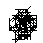

In [10]:
visualize(data_grids[0])

In [11]:
data_n_max[0]

16.0

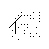

In [12]:
visualize(data_grids[-2])

In [13]:
data_n_max[-2]

69.0

Maximum values of `n`:

In [14]:
np.max(data_n_max)

89.0

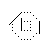

In [15]:
visualize(data_grids[np.argmax(data_n_max)])

Create a Pandas dataframe:

In [16]:
dataframe = pd.DataFrame(zip(data_grids, data_n_avg, data_n_std, data_n_max),
                         columns = ['grid', 'n_avg', 'n_std', 'n_max']) 

Shuffle the data:

In [17]:
dataframe = dataframe.sample(frac=1).reset_index(drop=True)

# DataLoaders

In [18]:
GRID_SIZE = 17

The `x` value is a grid of size `GRID_SIZE x GRID_SIZE`, with the actual grid loaded from the dataframe inserted at a random position:

In [19]:
def get_x(data):
    grid = data['grid']
    c, w, h = grid.shape
    if w < GRID_SIZE:
        px = np.random.randint(GRID_SIZE - w)
    else:
        px = 0
    if h < GRID_SIZE:
        py = np.random.randint(GRID_SIZE - h)
    else:
        py = 0
    x = torch.zeros((c, GRID_SIZE, GRID_SIZE))
    x[:,px:px+w,py:py+h] = torch.tensor(grid)
    return x

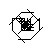

In [20]:
visualize(dataframe['grid'].iloc[0])

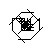

In [21]:
visualize(get_x(dataframe.iloc[0]))

The `y` value is a 2-plet containing the maximum of `n` and its standard deviation

In [22]:
# def get_y(data):
#     return (torch.tensor(data['n_max']).float(),
#            torch.tensor(data['n_std']).float())

For `y`, we want a number between 0 and 1, based on `n` that is a non-negative integer (positive or zero), potentially unbounded. We map it to the unit interval using
$$
y = \frac{n + 1}{n + n_* + 2},
$$
so that $s(0) = 1/(n_* + 2)$, $s(n_*) = 0.5$, and $s(\infty) = 1$. The distribution of $y$ in the unit interval depends on the choice of $n_*$. If we take $n_*$ small, say for instance $n_* = 1$, then the model will discriminate best among low values of $n$; if on the contrary we take $n_*$ big, then the model will discriminate best among large values of $n$.

In [23]:
N_STAR = 1

In [44]:
def get_y(data):
    n = torch.tensor([data['n_max']]).float()
    return (n + 1) / (n + N_STAR + 2)

We also define the inverse function, that takes `y` to `n`. This will be useful for inference at the end of the day:

In [58]:
def n_of_y(y):
    return (N_STAR + 1) * y / (1 - y) - 1

In [46]:
def n_of_x(x):
    return (N_STAR + 1) * torch.exp(x) - 1

DataBlock and DataLoaders:

In [47]:
dblock = DataBlock(get_x = get_x, get_y = get_y)

In [48]:
dls = dblock.dataloaders(dataframe, bs = 250)

Check one batch:

In [49]:
x_batch, y_batch = dls.one_batch()
x_batch.shape, y_batch.shape

(torch.Size([250, 5, 17, 17]), torch.Size([250, 1]))

In [51]:
y_batch[0:10]

tensor([[0.8333],
        [0.9718],
        [0.9649],
        [0.9623],
        [0.9574],
        [0.9655],
        [0.9474],
        [0.9710],
        [0.6667],
        [0.3333]])

## Convolutional neural network

Define the network architecture:

In [ ]:
# net = nn.Sequential(
#     nn.Conv2d(5, 64, stride = 1, kernel_size = 5, padding = 2),
#     nn.BatchNorm2d(64),
#     nn.ReLU(),
#     nn.Conv2d(64, 128, stride = 1, kernel_size = 3, padding = 1),
#     nn.BatchNorm2d(128),
#     nn.ReLU(),
#     nn.Conv2d(128, 256, stride = 1, kernel_size = 3, padding = 1),
#     nn.BatchNorm2d(256),
#     nn.ReLU(),
#     nn.AdaptiveAvgPool2d(1),
#     Flatten(),
#     nn.Linear(256, 1)
# )

In [ ]:
# net = nn.Sequential(
#     nn.Conv2d(5, 30, stride = 1, kernel_size = 5, padding = 2),
#     # image size: 32x32
#     nn.ReLU(),
#     nn.Conv2d(30, 60, stride = 2, kernel_size = 3, padding = 1),
#     # image size: 16x16
#     nn.ReLU(),
#     nn.Conv2d(60, 120, stride = 2, kernel_size = 3, padding = 1),
#     # image size: 8x8
#     nn.ReLU(),
#     nn.Conv2d(120, 120, stride = 2, kernel_size = 3, padding = 1),
#     # image size: 4x4
#     nn.ReLU(),
#     nn.Conv2d(120, 120, stride = 2, kernel_size = 3, padding = 1),
#     # image size: 2x2
#     nn.ReLU(),
#     nn.Conv2d(120, 1, stride = 2, kernel_size = 3, padding = 1),
#     # image size: 1x1
#     Flatten()
# )

In [ ]:
# net = xresnet18(c_in=5, n_out=1, ks=5, stride=1, stem_szs=(32,64,64))

In [54]:
net = nn.Sequential(
    # stem: use 3 layers with 3x3 kernel, and quite a few parameters
    nn.Conv2d(5, 32, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(32, 128, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    nn.Conv2d(128, 512, stride = 1, kernel_size = 3, padding = 1),
    nn.ReLU(),
    # flattening
    nn.AdaptiveMaxPool2d(1),
    Flatten(),
    # another couple of linear layers to perform basic operations
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1)
)

## Loss function and metrics

The model generically returns a real number $x$ distributed around 0. We first map this to the unit interval using the sigmoid fuction
$$ s(x) = \frac{1}{1 + e^{-x}},$$
after which $0 < s < 1$.

At the same time, $n$ is a non-negative integer (positive or zero), potentially unbounded. We map it to the unit interval using
$$
s(n) = \frac{n + 1}{n + n_* + 2},
$$
so that $s(0) = 1/(n_* + 2)$, $s(n_*) = 0.5$, and $s(\infty) = 1$. The distribution of $s$ in the unit interval depends on the choice of $n_*$. If we take $n_*$ small, say for instance $n_* = 1$, then the model will discriminate best among low values of $n$; if on the contrary we take $n_*$ big, then the model will discriminate best among large values of $n$. For now we choose an intermediate value $n_* = 5$.

To get from $x$ to $n$ directly, we can use
$$
    n = (n_* + 1) e^x - 1,
$$
or conversely
$$
    x = \log\left( \frac{n + 1}{n_* + 1} \right).
$$

For the **loss function**, we compute `s` both from the predictions and the targets and return the mean square error:

In [ ]:
# def mse_loss(predictions, targets):
#     predictions = 1/(1 + torch.exp(-predictions))
#     s = (targets[0] + 1)/(targets[0] + 10)
#     return torch.square(predictions - s).mean()

For the **metrics**, we compute `y` from the model predictions, round up the result to the nearest integer and compare with the target (possibly taking into account the standard deviation given with the target):

In [ ]:
# def n_accuracy_sigma(inputs, targets, sigma):
#     n_pred = 9 * torch.exp(inputs.squeeze(1)) - 1
#     return torch.where(torch.abs(n_pred - targets[0]) < 0.5 + sigma * targets[1], 1.0, 0.0).mean()

In [ ]:
# def n_accuracy_0(inputs, targets): return n_accuracy_sigma(inputs, targets, 0)
# def n_accuracy_1(inputs, targets): return n_accuracy_sigma(inputs, targets, 1)
# def n_accuracy_2(inputs, targets): return n_accuracy_sigma(inputs, targets, 2)

In [52]:
def n_accuracy(inputs, targets):
    n_pred = torch.round(n_of_x(inputs))
    n_targ = torch.round(n_of_y(targets))
    return torch.where(n_pred == n_targ, 1.0, 0.0).mean()

In [56]:
x_batch_pred = net(x_batch)
x_batch_pred.shape

torch.Size([250, 1])

In [59]:
n_accuracy(x_batch_pred, y_batch)

tensor(0.0360)

## Training

In [ ]:
# learn = Learner(dls, net, loss_func = mse_loss,
#                 metrics = [n_accuracy_0, n_accuracy_1, n_accuracy_2],
#                 cbs = ActivationStats(with_hist = True))

**WARNING**: this is probably a bad loss function for regression, but for now it seems to be working fine...

In [60]:
learn = Learner(dls, net, loss_func = nn.BCEWithLogitsLoss(),
                # loss_func = nn.MSELoss()
                metrics = n_accuracy,
                cbs = ActivationStats(with_hist = True))

In [62]:
# learn.summary()

In [ ]:
# learn.lr_find()

In [ ]:
learn.fit_one_cycle(10, lr_max = 5.0e-3)

epoch,train_loss,valid_loss,n_accuracy,time
0,0.405692,0.367650,0.007000,05:48
1,0.363832,0.346753,0.014333,05:29
2,0.341821,0.331976,0.025333,05:30


In [ ]:
learn.activation_stats.plot_layer_stats(0)

In [ ]:
learn.activation_stats.plot_layer_stats(-2)

In [ ]:
learn.activation_stats.color_dim(0)

In [ ]:
learn.activation_stats.color_dim(-2)

In [ ]:
# learn.export(fname = 'models/cross_5T_0.pkl')

In [ ]:
# torch.save(net, 'models/test.pkl')

## Inference

In [ ]:
x_valid, y_valid = dls.valid.one_batch()

In [ ]:
visualize(x_valid[0])

In [ ]:
y_valid[0], n_of_y(y_valid[0])

In [ ]:
x_preds = net(x_valid).data

In [ ]:
x_preds.squeeze().mean()

In [ ]:
x_preds.squeeze().std()

In [ ]:
n_preds = n_of_x(x_preds)

In [ ]:
n_preds.squeeze().mean(), n_preds.squeeze().std()